In [44]:
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.widgets import *
from fastai.vision.all import *
import time

In [30]:
def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [31]:
searchText = 'Golden Retreiver','German Shepherd', 'Dobermann', 'Golden Doodle'
path = Path('Dog_Types')
if not path.exists():
    path.mkdir()
    for o in searchText:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o} photo'))
        resize_images(path/o, max_size=400, dest=path/o)

/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [32]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#13) [None,None,None,None,None,None,None,None,None,None...]

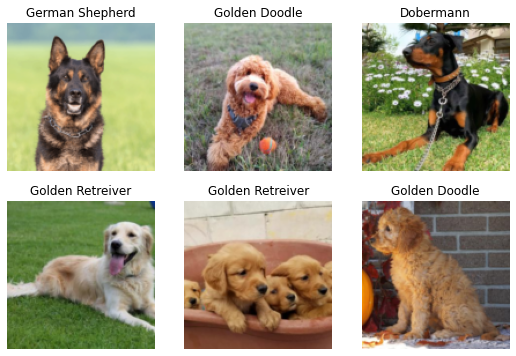

In [37]:
dataloaders = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
).dataloaders(path)

dataloaders.show_batch(max_n=6)

In [38]:
# dls = dataloaders.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms())
# dataloaders = dls.dataloaders(path)

In [39]:
learn = vision_learner(dataloaders, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.510378,0.335146,0.104575,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.434904,0.327404,0.098039,00:03
1,0.324164,0.299090,0.091503,00:03
2,0.240495,0.276736,0.065359,00:03
3,0.183401,0.282816,0.058824,00:03
4,0.152208,0.288729,0.071895,00:03
5,0.119954,0.275122,0.071895,00:03
6,0.099084,0.258892,0.065359,00:03
7,0.083566,0.255605,0.071895,00:03
8,0.072567,0.255514,0.071895,00:03
9,0.060950,0.262319,0.071895,00:03


In [40]:
learn.export()

In [41]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [52]:
learn_inf = load_learner(path/'export.pkl')

In [59]:
btn_upload = widgets.FileUpload()

In [60]:
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [61]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [62]:
btn_upload.observe(on_data_change, names=['data'])

In [63]:
display(VBox([widgets.Label('Input a picture of a dog:'), btn_upload, out_pl, lbl_pred]))